<a href="https://colab.research.google.com/github/KNUckle-llm/experiments/blob/main/knu_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# word -> pdf 파일로 변환(colab)
# Excel -> pdf 파일로 변환(colab)
# HWP -> PDF 파일로 변환(로컬)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요 라이브러리 설치
!pip install chromadb
!pip install sentence-transformers
!pip install pandas
!pip install pdfplumber

# ocr 설치
!apt-get install poppler-utils  # pdf2image 변환에 필요
!apt-get install tesseract-ocr
!pip install pytesseract pdf2image Pillow

In [ ]:
# ocr 제대로 설치되었는지 확인
!apt-get update
!apt-get install -y poppler-utils
!which pdfinfo

In [ ]:
# 구글 드라이브 document_files에 있는 파일들 전부 저장
import os, re, unicodedata, pytz, warnings, logging
import pandas as pd
import pdfplumber, pytesseract
from datetime import datetime
from PIL import Image, ImageEnhance, ImageFilter
from sentence_transformers import SentenceTransformer
from chromadb import PersistentClient
from pdf2image import convert_from_path

# 경고 무시 설정
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("pdfminer").setLevel(logging.ERROR)

# 설정
PERSIST_DIR = "/content/drive/MyDrive/chroma_index"
COLLECTION_NAME = "knu_collection"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L12-v2"
ROOT_FOLDER = "/content/drive/MyDrive/document_files"     # 여기만 바꾸기(경로)
URL_MAPPING_SUFFIX = "_url.xlsx"
POPPLER_PATH = "/usr/bin"  # Colab에서 poppler 경로

KST = pytz.timezone('Asia/Seoul')
model = SentenceTransformer(EMBEDDING_MODEL_NAME)
client = PersistentClient(path=PERSIST_DIR)
collection = client.get_or_create_collection(name=COLLECTION_NAME)
existing_ids = set(collection.get(limit=None)['ids'])

# 텍스트 전처리 함수
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def split_chunks(text, chunk_size=500):
    return [text[i:i+chunk_size].strip() for i in range(0, len(text), chunk_size)]

# ✅ OCR 기반 PDF 텍스트 추출 함수
def ocr_pdf(filepath):
    try:
        images = convert_from_path(filepath, dpi=300, poppler_path=POPPLER_PATH)
        text = ''
        for img in images:
            # 이미지 전처리 추가
            gray = img.convert('L')  # 흑백 변환
            gray = gray.filter(ImageFilter.MedianFilter())  # 노이즈 제거
            enhancer = ImageEnhance.Contrast(gray)
            enhanced = enhancer.enhance(2.0)  # 대비 증가
            bw = enhanced.point(lambda x: 0 if x < 140 else 255, '1')  # 이진화

            # OCR 수행
            text += pytesseract.image_to_string(
                bw,
                lang='kor+eng',
                config='--psm 6 --oem 3'
            ) + '\n'
        return text
    except Exception as e:
        print(f"❌ [OCR 실패] {filepath}: {e}")
        return ""

def read_file(filepath):
    if filepath.endswith(".pdf"):
        try:
            with pdfplumber.open(filepath) as pdf:
                text = ''.join([page.extract_text() or '' for page in pdf.pages])
            return text if text.strip() else ocr_pdf(filepath)
        except Exception as e:
            print(f"❌ [pdfplumber 실패] {filepath}: {e}")
            return ocr_pdf(filepath)
    elif filepath.endswith(".md"):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return f.read()
        except:
            return ""
    return ""

def get_all_files(folder):
    all_files = []
    for dirpath, _, filenames in os.walk(folder):
        for f in filenames:
            if f.endswith(('.pdf', '.md')):
                all_files.append(os.path.join(dirpath, f))
    return all_files

def extract_category(file_path, base_folder):
    rel_path = os.path.relpath(file_path, start=base_folder)
    parts = rel_path.split(os.sep)
    return parts[0] if len(parts) > 1 else "기타"

def build_metadata(file_path, base_folder, base_name, source_url, ext):
    category = extract_category(file_path, base_folder)
    department_path = os.path.relpath(base_folder, ROOT_FOLDER)

    # source_type을 pdf와 markdown으로만 설정
    source_type = "pdf" if ext == ".pdf" else "markdown"

    return {
        "file_name": base_name,
        "department": department_path,
        "category": category,
        "source_type": source_type,
        "source_url": source_url,
        "date": datetime.now(KST).isoformat()
    }

total_added = 0

# 엑셀 기준으로 저장
for dirpath, _, filenames in os.walk(ROOT_FOLDER):
    for filename in filenames:
        if filename.endswith(URL_MAPPING_SUFFIX):
            folder = dirpath  # 엑셀 위치 폴더 = 기준 폴더
            dept_folder_name = os.path.basename(folder)
            url_file = os.path.join(folder, filename)

            try:
                url_df = pd.read_excel(url_file)
                url_mapping = dict(zip(url_df['파일명'], url_df['URL']))
            except Exception as e:
                print(f"❌ URL 매핑 실패: {url_file} ({e})")
                continue

            file_paths = get_all_files(folder)

            for file_path in file_paths:
                file_name = os.path.basename(file_path)
                base_name = unicodedata.normalize("NFC", os.path.splitext(file_name)[0])
                ext = os.path.splitext(file_name)[1].lower()

                if file_name.endswith(URL_MAPPING_SUFFIX):
                    continue

                raw_text = read_file(file_path)
                if not raw_text.strip():
                    print(f"⚠️ {file_name}: 텍스트 없음 → 스킵")
                    continue

                cleaned = clean_text(raw_text)
                chunks = split_chunks(cleaned)
                embeddings = model.encode(chunks).tolist()
                ids = [f"{dept_folder_name}_{base_name}_chunk_{i}" for i in range(len(chunks))]

                new_chunks, new_embeddings, new_ids, new_metadatas = [], [], [], []

                for chunk, emb, id_ in zip(chunks, embeddings, ids):
                    if id_ not in existing_ids:
                        meta = build_metadata(file_path, folder, base_name, url_mapping.get(base_name, "출처 URL 없음"), ext)
                        new_chunks.append(chunk)
                        new_embeddings.append(emb)
                        new_ids.append(id_)
                        new_metadatas.append(meta)

                if new_chunks:
                    collection.add(
                        documents=new_chunks,
                        embeddings=new_embeddings,
                        metadatas=new_metadatas,
                        ids=new_ids
                    )
                    print(f"✅ {file_name}: {len(new_chunks)}개 저장 완료")
                    total_added += len(new_chunks)
                else:
                    print(f"✅✅✅ {file_name}: 중복 청크만 존재 → 스킵")

print(f"\n🎉 총 저장된 신규 청크 수: {total_added}")

In [ ]:
import random
from chromadb import PersistentClient

# 설정
PERSIST_DIR = "/content/drive/MyDrive/chroma_index"
COLLECTION_NAME = "knu_collection"

client = PersistentClient(path=PERSIST_DIR)
collection = client.get_or_create_collection(name=COLLECTION_NAME)

# 전체 문서 불러오기
results = collection.get(limit=None, include=["documents", "metadatas", "embeddings"])
total_docs = len(results['ids'])

print(f"\n📦 전체 저장된 벡터 수: {total_docs}")
print("=" * 70)

# 10개 무작위 추출
sample_indices = random.sample(range(total_docs), min(10, total_docs))

for i in sample_indices:
    doc_id = results["ids"][i]
    metadata = results["metadatas"][i]
    doc_text = results["documents"][i].strip().replace("\n", " ")
    embedding = results["embeddings"][i]

    print(f"🔹 ID: {doc_id}")
    print(f"   📁 파일명: {metadata.get('file_name')}")
    print(f"   🏫 부서: {metadata.get('department')}")
    print(f"   📂 카테고리: {metadata.get('category')}")
    print(f"   📄 타입: {metadata.get('source_type')}")
    print(f"   🌐 URL: {metadata.get('source_url')}")
    print(f"   📅 날짜: {metadata.get('date')[:10]}")
    print(f"   💬 청크 문장: {doc_text[:200]}...")  # 200자까지만 표시
    print(f"   🧠 벡터 길이: {len(embedding)}")
    print(f"   🔢 벡터 앞 5개 값: {embedding[:5]}")
    print("-" * 70)


In [63]:
# 완전 내부 초기화 ------ 신중히 사용하기 바람 -------
"""
from chromadb import PersistentClient

PERSIST_DIR = "/content/drive/MyDrive/chroma_index"
COLLECTION_NAME = "knu_collection"

client = PersistentClient(path=PERSIST_DIR)
collection = client.get_or_create_collection(name=COLLECTION_NAME)

# 컬렉션 내의 모든 문서 ID를 가져와 삭제
existing_ids = collection.get(limit=None)['ids']
if existing_ids:
    collection.delete(ids=existing_ids)
    print(f"🗑️ 컬렉션 내 모든 데이터 삭제 완료: {len(existing_ids)}개 삭제됨")
else:
    print("✅ 삭제할 데이터가 없습니다. 컬렉션이 이미 비어있습니다.")
"""

🗑️ 컬렉션 내 모든 데이터 삭제 완료: 1064개 삭제됨


✅ 총 1페이지 변환됨

📄 페이지 1 OCR 결과



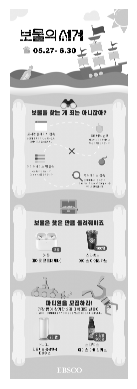

📜 텍스트:

ps 1 AA f
L pel a aS . N “f
W248 — X li SP
ol | Gq % oo
7 05.2/- 6.30 “~ ,
NS
C ee
se Z= A A= OU ZO
mH ae x= _ 4 _ Ls ?
M2 SwO|A| AA
GA SHolz| Gs DB G+ Ale
eto] 442/01 Re SA Ael Of] 4-04] Ay C4] O] EY eH]O] A
Sh/0lza|2 ASetelct. ce DBS MENStL|Ch.
a
: 6
HJO|E{HJO|A 4 Bet
Academic Search™
Completes S2/etLlct. OlE{HJOJ|A Ws
O/E}T/O| AO] AAot FI,
Business Source® CompleteS
IS MEWSEL|CH.
Bo zsCO O}= = AI0ES
nH — a OF Sse Cir Via
< E> >
=~ / mi \ 4 LAN
ae
@ aE
iS ARH A
HOW DH (3 eI) OFOIA OFM Are
OO az
A= D2! Obel An 4
MEAS SHH
. . io
TeAt BLO] ALHSt 27H CHSHOS ASO |” LE
*T ABE TOMO St HA SRS AWAD HOA SIWSUO. «Se
eM a I as
NUGU AEH A
MSS SHolA OOIA OFC 7 F&e
LiHrO|~
----------------------------------------------------------------------


In [78]:
#변환 실패

In [ ]:
"""
# 워드 파일 -> pdf 파일로 변환 예시
input_docx = "/content/drive/MyDrive/sample/[공통]_친환경_화장품_창업_공모전_코코챌린지_안내(KT&G_상상마당)_새글_비기너_트랙_참가신청서.docx"
output_md = "/content/drive/MyDrive/sample/[공통]_친환경_화장품_창업_공모전_코코챌린지_안내(KT&G_상상마당)_새글_비기너_트랙_참가신청서.md"


# 엑셀 파일 -> pdf 변환 해야함
"""